In [1]:
import sys
sys.path.append('/lfs/1/danfu/metal')
import metal

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [27]:
import pickle
import rekall
from rekall.video_interval_collection import VideoIntervalCollection
from rekall.interval_list import IntervalList
from rekall.temporal_predicates import *
import numpy as np
from scipy.sparse import csr_matrix
import os
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

from metal.analysis import lf_summary
from metal.label_model.baselines import MajorityLabelVoter
from metal.label_model import LabelModel

# Load Shot Data

In [4]:
with open('../../data/shot_detection_folds.pkl', 'rb') as f:
    shot_detection_folds = pickle.load(f)

In [5]:
with open('../../data/manually_annotated_shots.pkl', 'rb') as f:
    shots = VideoIntervalCollection(pickle.load(f))

In [6]:
clips = shots.dilate(1).coalesce().dilate(-1)

100%|██████████| 28/28 [00:00<00:00, 55685.40it/s]


In [7]:
shot_boundaries = shots.map(
    lambda intrvl: (intrvl.start, intrvl.start, intrvl.payload)
).set_union(
    shots.map(lambda intrvl: (intrvl.end + 1, intrvl.end + 1, intrvl.payload))
).coalesce()

In [8]:
boundary_frames = {
    video_id: [
        intrvl.start
        for intrvl in shot_boundaries.get_intervallist(video_id).get_intervals()
    ]
    for video_id in shot_boundaries.get_allintervals()
}

In [9]:
video_ids = sorted(list(clips.get_allintervals().keys()))

In [10]:
frames_per_video = {
    video_id: sorted([
        f
        for interval in clips.get_intervallist(video_id).get_intervals()
        for f in range(interval.start, interval.end + 2)
    ])
    for video_id in video_ids
}

In [11]:
ground_truth = {
    video_id: [
        1 if f in boundary_frames[video_id] else 2
        for f in frames_per_video[video_id]
    ] 
    for video_id in video_ids
}

# Load Weak Labels

In [12]:
with open('../../data/frame_counts.pkl', 'rb') as f:
    frame_counts = pickle.load(f)

In [13]:
labeling_function_folders = [
    '../../data/shot_detection_weak_labels/rgb_hists_high_pre',
    '../../data/shot_detection_weak_labels/hsv_hists_high_pre',
#     '../../data/shot_detection_weak_labels/flow_hists_magnitude', # this is just really really bad
    '../../data/shot_detection_weak_labels/flow_hists_diffs_high_pre',
    '../../data/shot_detection_weak_labels/face_counts',
    '../../data/shot_detection_weak_labels/face_positions'
]

In [14]:
weak_labels_all = []
weak_labels_gt_only = []

In [15]:
for folder in labeling_function_folders:
    labels_for_function_all = {}
    labels_for_function_gt_only = {}
    for video_id in tqdm(video_ids):
        all_frames = IntervalList([
            (f+1, f+1, 0)
            for f in range(frame_counts[video_id])
        ])
        with open(os.path.join(folder, '{}.pkl'.format(video_id)), 'rb') as f:
            positive_boundaries, negative_boundaries = pickle.load(f)
            positive_frames = IntervalList([
                (f, f, 1)
                for f in positive_boundaries if f <= frame_counts[video_id]
            ])
            negative_frames = IntervalList([
                (f, f, 2)
                for f in negative_boundaries if f <= frame_counts[video_id]
            ])
            frames_w_labels = all_frames.set_union(
                positive_frames
            ).set_union(
                negative_frames
            ).coalesce(payload_merge_op = lambda p1, p2: max(p1, p2))
            
            labels_for_function_all[video_id] = [
                intrvl.payload
                for intrvl in frames_w_labels.get_intervals()
            ]
            
            labels_for_function_gt_only[video_id] = [
                frames_w_labels.get_intervals()[f-1].payload
                for f in frames_per_video[video_id]
            ]
            
    weak_labels_all.append(labels_for_function_all)
    weak_labels_gt_only.append(labels_for_function_gt_only)

100%|██████████| 28/28 [00:34<00:00,  1.38s/it]


In [16]:
Y = np.array([
    label
    for video_id in video_ids
    for label in ground_truth[video_id]
])

In [17]:
Y.shape

(58153,)

In [18]:
L = csr_matrix([
    [
        label
        for video_id in video_ids
        for label in lf[video_id]
    ]
    for lf in weak_labels_gt_only
]).transpose()

In [19]:
L.shape

(58153, 5)

In [20]:
lf_summary(L, Y=Y, lf_names = ['RGB hist', 'HSV hist', 'flow hist', 'face counts', 'face positions'])

/lfs/1/danfu/metal/metal/analysis.py:142: RuntimeWarning: invalid value encountered in true_divide
  return tps / (tps + fps)


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.,Precision,Recall,F1
RGB hist,0,"[1, 2]",0.787406,0.772411,0.187557,45628,162,0.996462,0.744038,0.997868,0.852459
HSV hist,1,"[1, 2]",0.747425,0.737382,0.175967,43327,138,0.996825,0.787926,0.998039,0.880623
flow hist,2,"[1, 2]",0.719395,0.662820,0.165219,41323,512,0.987761,0.405832,0.935574,0.566102
face counts,3,2,0.505357,0.505357,0.239712,29334,54,0.998163,NaN,0.000000,NaN
face positions,4,"[1, 2]",0.505357,0.505357,0.239712,15516,13872,0.527971,0.003021,0.777778,0.006019


# Train Label Model

## Part 0: Majority Vote

In [21]:
for i in range(5):
    test_fold = shot_detection_folds[i]
    train_videos = [
        video_id
        for video_id in video_ids if video_id not in test_fold
    ]
    test_videos = [
        video_id
        for video_id in video_ids if video_id in test_fold
    ]
    
    Y_test = np.array([
        label
        for video_id in test_videos
        for label in ground_truth[video_id]
    ])
    L_test = csr_matrix([
        [
            label
            for video_id in test_videos
            for label in lf[video_id]
        ]
        for lf in weak_labels_gt_only
    ]).transpose()
    
    mv = MajorityLabelVoter(seed=123)
    scores = mv.score((L_test, Y_test), metric=['accuracy','precision', 'recall', 'f1'])

Accuracy: 0.965
Precision: 0.227
Recall: 0.933
F1: 0.365
        y=1    y=2   
 l=1    126    429   
 l=2     9    12108  
Accuracy: 0.977
Precision: 0.525
Recall: 0.822
F1: 0.641
        y=1    y=2   
 l=1    83     75    
 l=2    18    3951   
Accuracy: 0.970
Precision: 0.214
Recall: 0.983
F1: 0.351
        y=1    y=2   
 l=1    170    626   
 l=2     3    20486  
Accuracy: 0.966
Precision: 0.244
Recall: 0.921
F1: 0.386
        y=1    y=2   
 l=1    93     288   
 l=2     8    8418   
Accuracy: 0.970
Precision: 0.285
Recall: 0.915
F1: 0.435
        y=1    y=2   
 l=1    130    326   
 l=2    12    10794  


```
Accuracy: 0.965
Precision: 0.227
Recall: 0.933
F1: 0.365
        y=1    y=2   
 l=1    126    429   
 l=2     9    12108  
Accuracy: 0.977
Precision: 0.525
Recall: 0.822
F1: 0.641
        y=1    y=2   
 l=1    83     75    
 l=2    18    3951   
Accuracy: 0.970
Precision: 0.214
Recall: 0.983
F1: 0.351
        y=1    y=2   
 l=1    170    626   
 l=2     3    20486  
Accuracy: 0.966
Precision: 0.244
Recall: 0.921
F1: 0.386
        y=1    y=2   
 l=1    93     288   
 l=2     8    8418   
Accuracy: 0.970
Precision: 0.285
Recall: 0.915
F1: 0.435
        y=1    y=2   
 l=1    130    326   
 l=2    12    10794  
 
Average F1: .436
```

## Part 1: Train only on frames that we have gold labels for

In [22]:
for i in range(5):
    test_fold = shot_detection_folds[i]
    train_videos = [
        video_id
        for video_id in video_ids if video_id not in test_fold
    ]
    test_videos = [
        video_id
        for video_id in video_ids if video_id in test_fold
    ]
    
    L_train = csr_matrix([
        [
            label
            for video_id in train_videos
            for label in lf[video_id]
        ]
        for lf in weak_labels_gt_only
    ]).transpose()
    
    Y_test = np.array([
        label
        for video_id in test_videos
        for label in ground_truth[video_id]
    ])
    L_test = csr_matrix([
        [
            label
            for video_id in test_videos
            for label in lf[video_id]
        ]
        for lf in weak_labels_gt_only
    ]).transpose()
    
    label_model = LabelModel(k=2, seed=123)
    label_model.train_model(L_train, class_balance=(0.01, 0.99), n_epochs=500, log_train_every=50)
    label_model.score((L_test, Y_test), metric=['accuracy','precision', 'recall', 'f1'])

Computing O...
Estimating \mu...
[50 epo]: TRAIN:[loss=0.079]
[100 epo]: TRAIN:[loss=0.061]
[150 epo]: TRAIN:[loss=0.061]
[200 epo]: TRAIN:[loss=0.061]
[250 epo]: TRAIN:[loss=0.061]
[300 epo]: TRAIN:[loss=0.061]
[350 epo]: TRAIN:[loss=0.061]
[400 epo]: TRAIN:[loss=0.061]
[450 epo]: TRAIN:[loss=0.061]
[500 epo]: TRAIN:[loss=0.061]
Finished Training
Accuracy: 0.996
Precision: 0.877
Recall: 0.741
F1: 0.803
        y=1    y=2   
 l=1    100    14    
 l=2    35    12523  
Computing O...
Estimating \mu...
[50 epo]: TRAIN:[loss=0.080]
[100 epo]: TRAIN:[loss=0.062]
[150 epo]: TRAIN:[loss=0.062]
[200 epo]: TRAIN:[loss=0.062]
[250 epo]: TRAIN:[loss=0.062]
[300 epo]: TRAIN:[loss=0.062]
[350 epo]: TRAIN:[loss=0.062]
[400 epo]: TRAIN:[loss=0.062]
[450 epo]: TRAIN:[loss=0.061]
[500 epo]: TRAIN:[loss=0.061]
Finished Training
Accuracy: 0.986
Precision: 1.000
Recall: 0.426
F1: 0.597
        y=1    y=2   
 l=1    43      0    
 l=2    58    4026   
Computing O...
Estimating \mu...
[50 epo]: TRAIN:[loss

Results per fold:

```
Accuracy: 0.996
Precision: 0.877
Recall: 0.741
F1: 0.803
        y=1    y=2   
 l=1    100    14    
 l=2    35    12523  

Accuracy: 0.986
Precision: 1.000
Recall: 0.426
F1: 0.597
        y=1    y=2   
 l=1    43      0    
 l=2    58    4026   

Accuracy: 0.999
Precision: 0.975
Recall: 0.896
F1: 0.934
        y=1    y=2   
 l=1    155     4    
 l=2    18    21108  

Accuracy: 0.994
Precision: 0.807
Recall: 0.663
F1: 0.728
        y=1    y=2   
 l=1    67     16    
 l=2    34    8690   

Accuracy: 0.996
Precision: 0.952
Recall: 0.697
F1: 0.805
        y=1    y=2   
 l=1    99      5    
 l=2    43    11115  
 
Average F1: .773
```

## Part 2: Train on entire movies

In [23]:
prediction_probabilities = []

In [25]:
for i in range(5):
    test_fold = shot_detection_folds[i]
    train_videos = [
        video_id
        for video_id in video_ids if video_id not in test_fold
    ]
    test_videos = [
        video_id
        for video_id in video_ids if video_id in test_fold
    ]
    
    L_train = csr_matrix([
        [
            label
            for video_id in train_videos
            for label in lf[video_id]
        ]
        for lf in weak_labels_all
    ]).transpose()
    
    Y_test = np.array([
        label
        for video_id in test_videos
        for label in ground_truth[video_id]
    ])
    L_test = csr_matrix([
        [
            label
            for video_id in test_videos
            for label in lf[video_id]
        ]
        for lf in weak_labels_gt_only
    ]).transpose()
    
    label_model = LabelModel(k=2, seed=123)
    label_model.train_model(L_train, class_balance=(0.01, 0.99), n_epochs=500, log_train_every=50)
    label_model.score((L_test, Y_test), metric=['accuracy','precision', 'recall', 'f1'])
    
    Y_readable = [
        (video_id, f, 1 if f in boundary_frames[video_id] else 2)
        for video_id in test_videos
        for f in frames_per_video[video_id]
    ]
    
    predictions = label_model.predict(L_test)
    prediction_probs = label_model.predict_proba(L_test)
    prediction_probabilities.append([p[0] for p in prediction_probs])
    
    wrong_predictions = np.where(predictions != Y_test)[0]
    
    wrong_interval_preds = [
        (Y_readable[int(wp)], prediction_probs[int(wp)].tolist())
        for wp in wrong_predictions
    ]

    with open('../../data/failure_cases/metal_frame_only/{}_fold.pkl'.format(i + 1), 'wb') as f:
        pickle.dump(wrong_interval_preds, f)

Computing O...
Estimating \mu...
[50 epo]: TRAIN:[loss=0.078]
[100 epo]: TRAIN:[loss=0.062]
[150 epo]: TRAIN:[loss=0.062]
[200 epo]: TRAIN:[loss=0.062]
[250 epo]: TRAIN:[loss=0.062]
[300 epo]: TRAIN:[loss=0.062]
[350 epo]: TRAIN:[loss=0.062]
[400 epo]: TRAIN:[loss=0.062]
[450 epo]: TRAIN:[loss=0.062]
[500 epo]: TRAIN:[loss=0.062]
Finished Training
Accuracy: 0.996
Precision: 0.877
Recall: 0.741
F1: 0.803
        y=1    y=2   
 l=1    100    14    
 l=2    35    12523  
Computing O...
Estimating \mu...
[50 epo]: TRAIN:[loss=0.076]
[100 epo]: TRAIN:[loss=0.063]
[150 epo]: TRAIN:[loss=0.063]
[200 epo]: TRAIN:[loss=0.063]
[250 epo]: TRAIN:[loss=0.063]
[300 epo]: TRAIN:[loss=0.063]
[350 epo]: TRAIN:[loss=0.063]
[400 epo]: TRAIN:[loss=0.063]
[450 epo]: TRAIN:[loss=0.063]
[500 epo]: TRAIN:[loss=0.063]
Finished Training
Accuracy: 0.986
Precision: 1.000
Recall: 0.426
F1: 0.597
        y=1    y=2   
 l=1    43      0    
 l=2    58    4026   
Computing O...
Estimating \mu...
[50 epo]: TRAIN:[loss

```
Accuracy: 0.996
Precision: 0.877
Recall: 0.741
F1: 0.803
        y=1    y=2   
 l=1    100    14    
 l=2    35    12523  

Accuracy: 0.986
Precision: 1.000
Recall: 0.426
F1: 0.597
        y=1    y=2   
 l=1    43      0    
 l=2    58    4026   

Accuracy: 0.999
Precision: 0.975
Recall: 0.896
F1: 0.934
        y=1    y=2   
 l=1    155     4    
 l=2    18    21108  

Accuracy: 0.994
Precision: 0.807
Recall: 0.663
F1: 0.728
        y=1    y=2   
 l=1    67     16    
 l=2    34    8690   

Accuracy: 0.996
Precision: 0.952
Recall: 0.697
F1: 0.805
        y=1    y=2   
 l=1    99      5    
 l=2    43    11115  
 
Average F1: .773
```

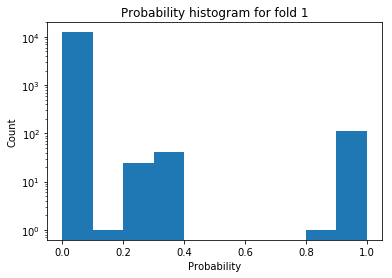

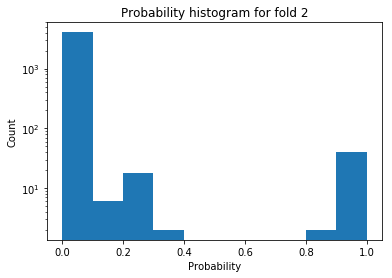

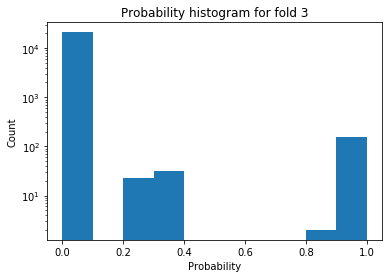

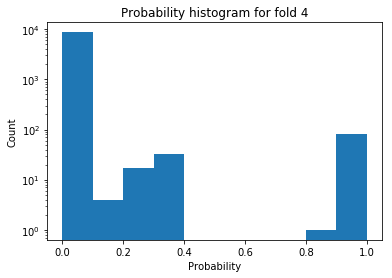

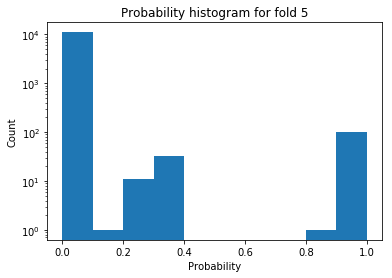

In [28]:
for i, problist in enumerate(prediction_probabilities):
    plt.hist(
        problist,
        log=True)
    plt.title('Probability histogram for fold {}'.format(i + 1))
    plt.xlabel('Probability')
    plt.ylabel('Count')
    plt.show()

## Part 3: Classify windows of 16 frames

### Labeling Functions for windows of 16 frames

In [29]:
# First, construct windows of 16 frames for each video
windows = VideoIntervalCollection({
    video_id: [
        (f, f + 16, video_id)
        for f in range(0, frame_counts[video_id] - 16, 8)
    ]
    for video_id in video_ids
})

In [30]:
# Next, intersect the windows with ground truth and get ground truth labels for the windows
windows_intersecting_ground_truth = windows.filter_against(
    clips,
    predicate=overlaps()
).map(lambda intrvl: (intrvl.start, intrvl.end, 2))
windows_with_shot_boundaries = windows_intersecting_ground_truth.filter_against(
    shot_boundaries,
    predicate = lambda window, shot_boundary:
        shot_boundary.start >= window.start and shot_boundary.start < window.end
).map(
    lambda intrvl: (intrvl.start, intrvl.end, 1)
)
windows_with_labels = windows_with_shot_boundaries.set_union(
    windows_intersecting_ground_truth
).coalesce(
    predicate = equal(),
    payload_merge_op = lambda p1, p2: min(p1, p2)
)

In [31]:
# Label windows with the weak labels in our labeling functions
def label_window(per_frame_weak_labels):
    if 1 in per_frame_weak_labels:
        return 1
    if len([l for l in per_frame_weak_labels if l == 2]) >= len(per_frame_weak_labels) / 2:
        return 2
    return 0

windows_with_weak_labels = windows.map(
    lambda window: (
        window.start,
        window.end,
        [
            label_window([
                lf[window.payload][f-1]
                for f in range(window.start, window.end)
            ])
            for lf in weak_labels_all
        ]
    )
)

In [32]:
Y_windows = np.array([
    intrvl.payload
    for video_id in video_ids
    for intrvl in windows_with_labels.get_intervallist(video_id).get_intervals()
])

In [33]:
Y_windows.shape

(7326,)

In [34]:
len([y for y in Y_windows if y == 1])

1290

In [35]:
L_windows = csr_matrix([
    intrvl.payload
    for video_id in video_ids
    for intrvl in windows_with_weak_labels.filter_against(
        clips, predicate=overlaps(), working_window=1
    ).get_intervallist(video_id).get_intervals()
])

In [36]:
L_windows.shape

(7326, 5)

In [37]:
lf_summary(L_windows, Y=Y_windows, lf_names = ['RGB hist', 'HSV hist', 'flow hist', 'face counts', 'face positions'])

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.,Precision,Recall,F1
RGB hist,0,"[1, 2]",0.885203,0.875512,0.375785,6039,446,0.931226,0.863927,0.761062,0.809239
HSV hist,1,"[1, 2]",0.860087,0.855037,0.365274,5955,346,0.945088,0.893728,0.820800,0.855713
flow hist,2,"[1, 2]",0.823096,0.795932,0.351351,5465,565,0.906302,0.783415,0.700698,0.739751
face counts,3,2,0.531668,0.531668,0.335108,3523,372,0.904493,NaN,0.000000,NaN
face positions,4,"[1, 2]",0.566749,0.564565,0.356265,1814,2338,0.436898,0.132853,0.660040,0.221186


In [38]:
csr_matrix([
    intrvl.payload
    for video_id in video_ids
    for intrvl in windows_with_weak_labels.get_intervallist(video_id).get_intervals()
]).shape

(591762, 5)

### Part 0: Majority Vote

In [39]:
windows_with_weak_labels_gt_only = windows_with_weak_labels.filter_against(
    clips, predicate=overlaps(), working_window=1
)
for i in range(5):
    test_fold = shot_detection_folds[i]
    train_videos = [
        video_id
        for video_id in video_ids if video_id not in test_fold
    ]
    test_videos = [
        video_id
        for video_id in video_ids if video_id in test_fold
    ]
    
    Y_test = np.array([
        intrvl.payload
        for video_id in test_videos
        for intrvl in windows_with_labels.get_intervallist(video_id).get_intervals()
    ])
    L_test = csr_matrix([
        intrvl.payload
        for video_id in test_videos
        for intrvl in windows_with_weak_labels_gt_only.get_intervallist(video_id).get_intervals()
    ])
    
    mv = MajorityLabelVoter(seed=123)
    scores = mv.score((L_test, Y_test), metric=['accuracy','precision', 'recall', 'f1'])

Accuracy: 0.908
Precision: 0.697
Recall: 0.791
F1: 0.741
        y=1    y=2   
 l=1    212    92    
 l=2    56    1246   
Accuracy: 0.806
Precision: 0.902
Recall: 0.555
F1: 0.687
        y=1    y=2   
 l=1    111    12    
 l=2    89     309   
Accuracy: 0.951
Precision: 0.767
Recall: 0.887
F1: 0.823
        y=1    y=2   
 l=1    306    93    
 l=2    39    2229   
Accuracy: 0.904
Precision: 0.735
Recall: 0.743
F1: 0.739
        y=1    y=2   
 l=1    150    54    
 l=2    52     849   
Accuracy: 0.921
Precision: 0.807
Recall: 0.775
F1: 0.790
        y=1    y=2   
 l=1    213    51    
 l=2    62    1101   


```
Accuracy: 0.908
Precision: 0.697
Recall: 0.791
F1: 0.741
        y=1    y=2   
 l=1    212    92    
 l=2    56    1246   
Accuracy: 0.806
Precision: 0.902
Recall: 0.555
F1: 0.687
        y=1    y=2   
 l=1    111    12    
 l=2    89     309   
Accuracy: 0.951
Precision: 0.767
Recall: 0.887
F1: 0.823
        y=1    y=2   
 l=1    306    93    
 l=2    39    2229   
Accuracy: 0.904
Precision: 0.735
Recall: 0.743
F1: 0.739
        y=1    y=2   
 l=1    150    54    
 l=2    52     849   
Accuracy: 0.921
Precision: 0.807
Recall: 0.775
F1: 0.790
        y=1    y=2   
 l=1    213    51    
 l=2    62    1101      

Average F1: .756
```

### Part 1: Train LabelModel on frames that we have GT for

In [40]:
# manual class balance
windows_with_weak_labels_gt_only = windows_with_weak_labels.filter_against(
    clips, predicate=overlaps(), working_window=1
)
for i in range(5):
    test_fold = shot_detection_folds[i]
    train_videos = [
        video_id
        for video_id in video_ids if video_id not in test_fold
    ]
    test_videos = [
        video_id
        for video_id in video_ids if video_id in test_fold
    ]
    
    L_train = csr_matrix([
        intrvl.payload
        for video_id in train_videos
        for intrvl in windows_with_weak_labels_gt_only.get_intervallist(video_id).get_intervals()
    ])
    
    Y_test = np.array([
        intrvl.payload
        for video_id in test_videos
        for intrvl in windows_with_labels.get_intervallist(video_id).get_intervals()
    ])
    L_test = csr_matrix([
        intrvl.payload
        for video_id in test_videos
        for intrvl in windows_with_weak_labels_gt_only.get_intervallist(video_id).get_intervals()
    ])
    
    label_model = LabelModel(k=2, seed=123)
    label_model.train_model(L_train, class_balance=(0.15, 0.85), n_epochs=500, log_train_every=50)
    label_model.score((L_test, Y_test), metric=['accuracy','precision', 'recall', 'f1'])

Computing O...
Estimating \mu...
[50 epo]: TRAIN:[loss=0.065]
[100 epo]: TRAIN:[loss=0.045]
[150 epo]: TRAIN:[loss=0.040]
[200 epo]: TRAIN:[loss=0.040]
[250 epo]: TRAIN:[loss=0.040]
[300 epo]: TRAIN:[loss=0.039]
[350 epo]: TRAIN:[loss=0.039]
[400 epo]: TRAIN:[loss=0.039]
[450 epo]: TRAIN:[loss=0.039]
[500 epo]: TRAIN:[loss=0.039]
Finished Training
Accuracy: 0.933
Precision: 0.823
Recall: 0.765
F1: 0.793
        y=1    y=2   
 l=1    205    44    
 l=2    63    1294   
Computing O...
Estimating \mu...
[50 epo]: TRAIN:[loss=0.069]
[100 epo]: TRAIN:[loss=0.046]
[150 epo]: TRAIN:[loss=0.042]
[200 epo]: TRAIN:[loss=0.041]
[250 epo]: TRAIN:[loss=0.041]
[300 epo]: TRAIN:[loss=0.041]
[350 epo]: TRAIN:[loss=0.041]
[400 epo]: TRAIN:[loss=0.041]
[450 epo]: TRAIN:[loss=0.041]
[500 epo]: TRAIN:[loss=0.041]
Finished Training
Accuracy: 0.808
Precision: 0.963
Recall: 0.520
F1: 0.675
        y=1    y=2   
 l=1    104     4    
 l=2    96     317   
Computing O...
Estimating \mu...
[50 epo]: TRAIN:[loss

```
Accuracy: 0.933
Precision: 0.823
Recall: 0.765
F1: 0.793
        y=1    y=2   
 l=1    205    44    
 l=2    63    1294   
 
Accuracy: 0.808
Precision: 0.963
Recall: 0.520
F1: 0.675
        y=1    y=2   
 l=1    104     4    
 l=2    96     317   

Accuracy: 0.963
Precision: 0.882
Recall: 0.826
F1: 0.853
        y=1    y=2   
 l=1    285    38    
 l=2    60    2284   

Accuracy: 0.899
Precision: 0.781
Recall: 0.619
F1: 0.691
        y=1    y=2   
 l=1    125    35    
 l=2    77     868   

Accuracy: 0.931
Precision: 0.904
Recall: 0.720
F1: 0.802
        y=1    y=2   
 l=1    198    21    
 l=2    77    1131  
 
Average F1: .763
```

In [41]:
windows_with_weak_labels_gt_only = windows_with_weak_labels.filter_against(
    clips, predicate=overlaps(), working_window=1
)
for i in range(5):
    test_fold = shot_detection_folds[i]
    train_videos = [
        video_id
        for video_id in video_ids if video_id not in test_fold
    ]
    test_videos = [
        video_id
        for video_id in video_ids if video_id in test_fold
    ]
    
    Y_train = np.array([
        intrvl.payload
        for video_id in train_videos
        for intrvl in windows_with_labels.get_intervallist(video_id).get_intervals()
    ])
    L_train = csr_matrix([
        intrvl.payload
        for video_id in train_videos
        for intrvl in windows_with_weak_labels_gt_only.get_intervallist(video_id).get_intervals()
    ])
    
    Y_test = np.array([
        intrvl.payload
        for video_id in test_videos
        for intrvl in windows_with_labels.get_intervallist(video_id).get_intervals()
    ])
    L_test = csr_matrix([
        intrvl.payload
        for video_id in test_videos
        for intrvl in windows_with_weak_labels_gt_only.get_intervallist(video_id).get_intervals()
    ])
    
    label_model = LabelModel(k=2, seed=123)
    label_model.train_model(L_train, Y_dev=Y_train, n_epochs=500, log_train_every=50)
    label_model.score((L_test, Y_test), metric=['accuracy','precision', 'recall', 'f1'])

Computing O...
Estimating \mu...
[50 epo]: TRAIN:[loss=0.063]
[100 epo]: TRAIN:[loss=0.043]
[150 epo]: TRAIN:[loss=0.040]
[200 epo]: TRAIN:[loss=0.040]
[250 epo]: TRAIN:[loss=0.039]
[300 epo]: TRAIN:[loss=0.039]
[350 epo]: TRAIN:[loss=0.039]
[400 epo]: TRAIN:[loss=0.039]
[450 epo]: TRAIN:[loss=0.039]
[500 epo]: TRAIN:[loss=0.039]
Finished Training
Accuracy: 0.936
Precision: 0.817
Recall: 0.799
F1: 0.808
        y=1    y=2   
 l=1    214    48    
 l=2    54    1290   
Computing O...
Estimating \mu...
[50 epo]: TRAIN:[loss=0.067]
[100 epo]: TRAIN:[loss=0.045]
[150 epo]: TRAIN:[loss=0.041]
[200 epo]: TRAIN:[loss=0.041]
[250 epo]: TRAIN:[loss=0.041]
[300 epo]: TRAIN:[loss=0.041]
[350 epo]: TRAIN:[loss=0.041]
[400 epo]: TRAIN:[loss=0.041]
[450 epo]: TRAIN:[loss=0.041]
[500 epo]: TRAIN:[loss=0.041]
Finished Training
Accuracy: 0.816
Precision: 0.964
Recall: 0.540
F1: 0.692
        y=1    y=2   
 l=1    108     4    
 l=2    92     317   
Computing O...
Estimating \mu...
[50 epo]: TRAIN:[loss

```
Accuracy: 0.936
Precision: 0.817
Recall: 0.799
F1: 0.808
        y=1    y=2   
 l=1    214    48    
 l=2    54    1290   

Accuracy: 0.816
Precision: 0.964
Recall: 0.540
F1: 0.692
        y=1    y=2   
 l=1    108     4    
 l=2    92     317   

Accuracy: 0.970
Precision: 0.884
Recall: 0.887
F1: 0.886
        y=1    y=2   
 l=1    306    40    
 l=2    39    2282   

Accuracy: 0.909
Precision: 0.785
Recall: 0.688
F1: 0.734
        y=1    y=2   
 l=1    139    38    
 l=2    63     865   

Accuracy: 0.940
Precision: 0.906
Recall: 0.771
F1: 0.833

Average F1: .791
```

### Part 2: Train LabelModel on entire videos

In [46]:
windows_with_weak_labels_gt_only = windows_with_weak_labels.filter_against(
    clips, predicate=overlaps(), working_window=1
)
prediction_probabilities_windows = []
for i in range(5):
    test_fold = shot_detection_folds[i]
    train_videos = [
        video_id
        for video_id in video_ids if video_id not in test_fold
    ]
    test_videos = [
        video_id
        for video_id in video_ids if video_id in test_fold
    ]
    
    L_train = csr_matrix([
        intrvl.payload
        for video_id in train_videos
        for intrvl in windows_with_weak_labels.get_intervallist(video_id).get_intervals()
    ])
    
    Y_test = np.array([
        intrvl.payload
        for video_id in test_videos
        for intrvl in windows_with_labels.get_intervallist(video_id).get_intervals()
    ])
    L_test = csr_matrix([
        intrvl.payload
        for video_id in test_videos
        for intrvl in windows_with_weak_labels_gt_only.get_intervallist(video_id).get_intervals()
    ])
    
    label_model = LabelModel(k=2, seed=123)
    label_model.train_model(L_train, class_balance=(0.15, 0.85), n_epochs=500, log_train_every=50)
    label_model.score((L_test, Y_test), metric=['accuracy','precision', 'recall', 'f1'])
    
    predictions = label_model.predict(L_test)
    prediction_probs = label_model.predict_proba(L_test)
    prediction_probabilities_windows.append([p[0] for p in prediction_probs])

Computing O...
Estimating \mu...
[50 epo]: TRAIN:[loss=0.070]
[100 epo]: TRAIN:[loss=0.054]
[150 epo]: TRAIN:[loss=0.049]
[200 epo]: TRAIN:[loss=0.047]
[250 epo]: TRAIN:[loss=0.047]
[300 epo]: TRAIN:[loss=0.047]
[350 epo]: TRAIN:[loss=0.047]
[400 epo]: TRAIN:[loss=0.047]
[450 epo]: TRAIN:[loss=0.047]
[500 epo]: TRAIN:[loss=0.047]
Finished Training
Accuracy: 0.938
Precision: 0.818
Recall: 0.806
F1: 0.812
        y=1    y=2   
 l=1    216    48    
 l=2    52    1290   
Computing O...
Estimating \mu...
[50 epo]: TRAIN:[loss=0.070]
[100 epo]: TRAIN:[loss=0.055]
[150 epo]: TRAIN:[loss=0.050]
[200 epo]: TRAIN:[loss=0.049]
[250 epo]: TRAIN:[loss=0.048]
[300 epo]: TRAIN:[loss=0.048]
[350 epo]: TRAIN:[loss=0.048]
[400 epo]: TRAIN:[loss=0.048]
[450 epo]: TRAIN:[loss=0.048]
[500 epo]: TRAIN:[loss=0.048]
Finished Training
Accuracy: 0.821
Precision: 0.957
Recall: 0.560
F1: 0.707
        y=1    y=2   
 l=1    112     5    
 l=2    88     316   
Computing O...
Estimating \mu...
[50 epo]: TRAIN:[loss

```
Accuracy: 0.938
Precision: 0.818
Recall: 0.806
F1: 0.812
        y=1    y=2   
 l=1    216    48    
 l=2    52    1290   

Accuracy: 0.821
Precision: 0.957
Recall: 0.560
F1: 0.707
        y=1    y=2   
 l=1    112     5    
 l=2    88     316   

Accuracy: 0.972
Precision: 0.883
Recall: 0.899
F1: 0.891
        y=1    y=2   
 l=1    310    41    
 l=2    35    2281   

Accuracy: 0.910
Precision: 0.778
Recall: 0.713
F1: 0.744
        y=1    y=2   
 l=1    144    41    
 l=2    58     862   

Accuracy: 0.940
Precision: 0.893
Recall: 0.785
F1: 0.836
        y=1    y=2   
 l=1    216    26    
 l=2    59    1126    

Average F1: .798
```

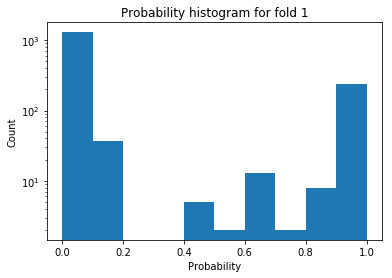

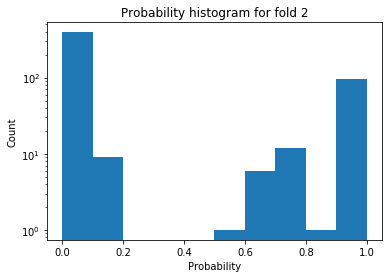

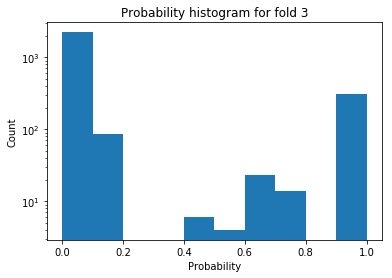

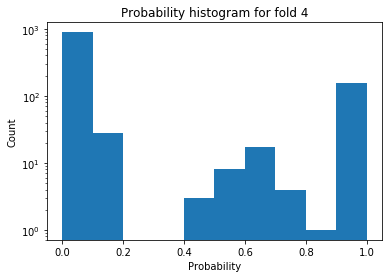

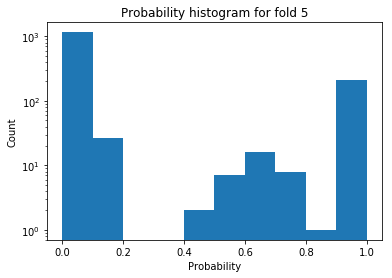

In [43]:
for i, problist in enumerate(prediction_probabilities_windows):
    plt.hist(
        problist,
        log=True)
    plt.title('Probability histogram for fold {}'.format(i + 1))
    plt.xlabel('Probability')
    plt.ylabel('Count')
    plt.show()

# Part 4: Training on the entire dataset

In [47]:
# First, load noisy labels from the entire dataset
video_ids_all = sorted(list(frame_counts.keys()))

In [49]:
weak_labels_all_movies = []
for folder in labeling_function_folders:
    labels_for_function_all = {}
    for video_id in tqdm(video_ids_all):
        all_frames = IntervalList([
            (f+1, f+1, 0)
            for f in range(frame_counts[video_id])
        ])
        with open(os.path.join(folder, '{}.pkl'.format(video_id)), 'rb') as f:
            positive_boundaries, negative_boundaries = pickle.load(f)
            positive_frames = IntervalList([
                (f, f, 1)
                for f in positive_boundaries if f <= frame_counts[video_id]
            ])
            negative_frames = IntervalList([
                (f, f, 2)
                for f in negative_boundaries if f <= frame_counts[video_id]
            ])
            frames_w_labels = all_frames.set_union(
                positive_frames
            ).set_union(
                negative_frames
            ).coalesce(payload_merge_op = lambda p1, p2: max(p1, p2))
            
            labels_for_function_all[video_id] = [
                intrvl.payload
                for intrvl in frames_w_labels.get_intervals()
            ]
            
    weak_labels_all_movies.append(labels_for_function_all)



  0%|          | 0/589 [00:00<?, ?it/s]

  0%|          | 1/589 [00:01<18:18,  1.87s/it]

  0%|          | 2/589 [00:03<17:38,  1.80s/it]

  1%|          | 3/589 [00:04<16:22,  1.68s/it]

  1%|          | 4/589 [00:06<15:52,  1.63s/it]

  1%|          | 5/589 [00:07<14:39,  1.51s/it]

  1%|          | 6/589 [00:08<12:19,  1.27s/it]

  1%|          | 7/589 [00:09<11:46,  1.21s/it]

  1%|▏         | 8/589 [00:10<10:21,  1.07s/it]

  2%|▏         | 9/589 [00:11<10:26,  1.08s/it]

  2%|▏         | 10/589 [00:11<09:13,  1.05it/s]

  2%|▏         | 11/589 [00:13<10:46,  1.12s/it]

  2%|▏         | 12/589 [00:14<10:44,  1.12s/it]

  2%|▏         | 13/589 [00:16<12:16,  1.28s/it]

  2%|▏         | 14/589 [00:16<09:20,  1.03it/s]

  3%|▎         | 15/589 [00:17<10:18,  1.08s/it]

  3%|▎         | 16/589 [00:19<10:49,  1.13s/it]

  3%|▎         | 17/589 [00:19<10:13,  1.07s/it]

  3%|▎         | 18/589 [00:21<11:08,  1.17s/it]

  3%|▎         | 19/589 [00:22<09:46,  1.03s/it]

  3%|▎         |

 49%|████▉     | 288/589 [06:05<07:28,  1.49s/it]

 49%|████▉     | 289/589 [06:06<07:21,  1.47s/it]

 49%|████▉     | 290/589 [06:07<06:47,  1.36s/it]

 49%|████▉     | 291/589 [06:08<06:38,  1.34s/it]

 50%|████▉     | 292/589 [06:09<05:44,  1.16s/it]

 50%|████▉     | 293/589 [06:11<06:28,  1.31s/it]

 50%|████▉     | 294/589 [06:12<05:49,  1.18s/it]

 50%|█████     | 295/589 [06:13<06:09,  1.26s/it]

 50%|█████     | 296/589 [06:15<06:30,  1.33s/it]

 50%|█████     | 297/589 [06:15<05:32,  1.14s/it]

 51%|█████     | 298/589 [06:17<06:22,  1.32s/it]

 51%|█████     | 299/589 [06:18<05:32,  1.15s/it]

 51%|█████     | 300/589 [06:19<05:57,  1.24s/it]

 51%|█████     | 301/589 [06:20<05:27,  1.14s/it]

 51%|█████▏    | 302/589 [06:22<06:13,  1.30s/it]

 51%|█████▏    | 303/589 [06:23<05:34,  1.17s/it]

 52%|█████▏    | 304/589 [06:24<05:59,  1.26s/it]

 52%|█████▏    | 305/589 [06:26<06:24,  1.35s/it]

 52%|█████▏    | 306/589 [06:27<05:58,  1.27s/it]

 52%|█████▏    | 307/589 [06:29

 97%|█████████▋| 574/589 [12:36<00:22,  1.49s/it]

 98%|█████████▊| 575/589 [12:38<00:22,  1.61s/it]

 98%|█████████▊| 576/589 [12:39<00:17,  1.37s/it]

 98%|█████████▊| 577/589 [12:41<00:17,  1.49s/it]

 98%|█████████▊| 578/589 [12:42<00:14,  1.31s/it]

 98%|█████████▊| 579/589 [12:43<00:13,  1.38s/it]

 98%|█████████▊| 580/589 [12:44<00:10,  1.20s/it]

 99%|█████████▊| 581/589 [12:46<00:11,  1.38s/it]

 99%|█████████▉| 582/589 [12:48<00:11,  1.58s/it]

 99%|█████████▉| 583/589 [12:50<00:09,  1.65s/it]

 99%|█████████▉| 584/589 [12:51<00:07,  1.43s/it]

 99%|█████████▉| 585/589 [12:53<00:06,  1.69s/it]

 99%|█████████▉| 586/589 [12:55<00:05,  1.95s/it]

100%|█████████▉| 587/589 [12:57<00:03,  1.91s/it]

100%|█████████▉| 588/589 [12:58<00:01,  1.65s/it]

100%|██████████| 589/589 [13:00<00:00,  1.67s/it]

  0%|          | 0/589 [00:00<?, ?it/s]

  0%|          | 1/589 [00:01<10:18,  1.05s/it]

  0%|          | 2/589 [00:02<12:03,  1.23s/it]

  1%|          | 3/589 [00:03<11:48,  1.21s/i

 46%|████▌     | 272/589 [06:39<09:11,  1.74s/it]

 46%|████▋     | 273/589 [06:40<07:35,  1.44s/it]

 47%|████▋     | 274/589 [06:41<06:30,  1.24s/it]

 47%|████▋     | 275/589 [06:43<07:41,  1.47s/it]

 47%|████▋     | 276/589 [06:44<08:11,  1.57s/it]

 47%|████▋     | 277/589 [06:46<07:26,  1.43s/it]

 47%|████▋     | 278/589 [06:47<07:56,  1.53s/it]

 47%|████▋     | 279/589 [06:49<08:43,  1.69s/it]

 48%|████▊     | 280/589 [06:50<07:15,  1.41s/it]

 48%|████▊     | 281/589 [06:52<08:27,  1.65s/it]

 48%|████▊     | 282/589 [06:54<07:43,  1.51s/it]

 48%|████▊     | 283/589 [06:56<08:27,  1.66s/it]

 48%|████▊     | 284/589 [06:58<09:10,  1.81s/it]

 48%|████▊     | 285/589 [06:59<07:55,  1.56s/it]

 49%|████▊     | 286/589 [07:01<08:30,  1.69s/it]

 49%|████▊     | 287/589 [07:01<06:55,  1.38s/it]

 49%|████▉     | 288/589 [07:04<08:27,  1.68s/it]

 49%|████▉     | 289/589 [07:06<08:33,  1.71s/it]

 49%|████▉     | 290/589 [07:08<09:06,  1.83s/it]

 49%|████▉     | 291/589 [07:08

 95%|█████████▍| 558/589 [14:08<00:42,  1.37s/it]

 95%|█████████▍| 559/589 [14:10<00:46,  1.55s/it]

 95%|█████████▌| 560/589 [14:12<00:49,  1.72s/it]

 95%|█████████▌| 561/589 [14:13<00:42,  1.52s/it]

 95%|█████████▌| 562/589 [14:15<00:45,  1.68s/it]

 96%|█████████▌| 563/589 [14:17<00:49,  1.92s/it]

 96%|█████████▌| 564/589 [14:18<00:41,  1.64s/it]

 96%|█████████▌| 565/589 [14:20<00:41,  1.72s/it]

 96%|█████████▌| 566/589 [14:21<00:32,  1.41s/it]

 96%|█████████▋| 567/589 [14:23<00:36,  1.64s/it]

 96%|█████████▋| 568/589 [14:24<00:29,  1.40s/it]

 97%|█████████▋| 569/589 [14:26<00:32,  1.63s/it]

 97%|█████████▋| 570/589 [14:27<00:27,  1.45s/it]

 97%|█████████▋| 571/589 [14:29<00:29,  1.66s/it]

 97%|█████████▋| 572/589 [14:31<00:30,  1.80s/it]

 97%|█████████▋| 573/589 [14:32<00:24,  1.53s/it]

 97%|█████████▋| 574/589 [14:35<00:26,  1.74s/it]

 98%|█████████▊| 575/589 [14:37<00:26,  1.90s/it]

 98%|█████████▊| 576/589 [14:38<00:20,  1.58s/it]

 98%|█████████▊| 577/589 [14:40

 43%|████▎     | 256/589 [07:05<11:04,  1.99s/it]

 44%|████▎     | 257/589 [07:06<09:17,  1.68s/it]

 44%|████▍     | 258/589 [07:08<10:43,  1.94s/it]

 44%|████▍     | 259/589 [07:11<11:21,  2.07s/it]

 44%|████▍     | 260/589 [07:12<09:37,  1.76s/it]

 44%|████▍     | 261/589 [07:14<10:17,  1.88s/it]

 44%|████▍     | 262/589 [07:15<08:34,  1.57s/it]

 45%|████▍     | 263/589 [07:17<09:35,  1.77s/it]

 45%|████▍     | 264/589 [07:19<10:25,  1.92s/it]

 45%|████▍     | 265/589 [07:21<09:18,  1.72s/it]

 45%|████▌     | 266/589 [07:23<10:24,  1.93s/it]

 45%|████▌     | 267/589 [07:24<08:49,  1.64s/it]

 46%|████▌     | 268/589 [07:26<09:51,  1.84s/it]

 46%|████▌     | 269/589 [07:28<10:13,  1.92s/it]

 46%|████▌     | 270/589 [07:29<08:43,  1.64s/it]

 46%|████▌     | 271/589 [07:32<09:50,  1.86s/it]

 46%|████▌     | 272/589 [07:33<08:26,  1.60s/it]

 46%|████▋     | 273/589 [07:35<09:09,  1.74s/it]

 47%|████▋     | 274/589 [07:36<07:56,  1.51s/it]

 47%|████▋     | 275/589 [07:38

 92%|█████████▏| 542/589 [15:33<01:32,  1.97s/it]

 92%|█████████▏| 543/589 [15:33<01:16,  1.65s/it]

 92%|█████████▏| 544/589 [15:36<01:24,  1.88s/it]

 93%|█████████▎| 545/589 [15:37<01:08,  1.55s/it]

 93%|█████████▎| 546/589 [15:39<01:21,  1.89s/it]

 93%|█████████▎| 547/589 [15:42<01:26,  2.05s/it]

 93%|█████████▎| 548/589 [15:43<01:11,  1.74s/it]

 93%|█████████▎| 549/589 [15:45<01:18,  1.97s/it]

 93%|█████████▎| 550/589 [15:48<01:23,  2.15s/it]

 94%|█████████▎| 551/589 [15:49<01:06,  1.75s/it]

 94%|█████████▎| 552/589 [15:51<01:10,  1.91s/it]

 94%|█████████▍| 553/589 [15:52<00:56,  1.58s/it]

 94%|█████████▍| 554/589 [15:54<01:04,  1.85s/it]

 94%|█████████▍| 555/589 [15:55<00:52,  1.55s/it]

 94%|█████████▍| 556/589 [15:57<00:58,  1.76s/it]

 95%|█████████▍| 557/589 [15:58<00:47,  1.47s/it]

 95%|█████████▍| 558/589 [16:01<00:55,  1.79s/it]

 95%|█████████▍| 559/589 [16:03<00:59,  1.97s/it]

 95%|█████████▌| 560/589 [16:04<00:48,  1.67s/it]

 95%|█████████▌| 561/589 [16:07

 41%|████      | 240/589 [06:44<09:15,  1.59s/it]

 41%|████      | 241/589 [06:45<07:42,  1.33s/it]

 41%|████      | 242/589 [06:47<09:34,  1.66s/it]

 41%|████▏     | 243/589 [06:48<08:08,  1.41s/it]

 41%|████▏     | 244/589 [06:50<10:14,  1.78s/it]

 42%|████▏     | 245/589 [06:51<08:21,  1.46s/it]

 42%|████▏     | 246/589 [06:54<10:04,  1.76s/it]

 42%|████▏     | 247/589 [06:57<11:59,  2.10s/it]

 42%|████▏     | 248/589 [06:58<10:14,  1.80s/it]

 42%|████▏     | 249/589 [07:00<11:42,  2.07s/it]

 42%|████▏     | 250/589 [07:03<12:30,  2.22s/it]

 43%|████▎     | 251/589 [07:04<09:56,  1.76s/it]

 43%|████▎     | 252/589 [07:04<08:02,  1.43s/it]

 43%|████▎     | 253/589 [07:07<09:31,  1.70s/it]

 43%|████▎     | 254/589 [07:08<08:13,  1.47s/it]

 43%|████▎     | 255/589 [07:10<10:06,  1.82s/it]

 43%|████▎     | 256/589 [07:13<11:48,  2.13s/it]

 44%|████▎     | 257/589 [07:14<09:35,  1.73s/it]

 44%|████▍     | 258/589 [07:16<10:59,  1.99s/it]

 44%|████▍     | 259/589 [07:17

 89%|████████▉ | 526/589 [15:17<02:13,  2.12s/it]

 89%|████████▉ | 527/589 [15:21<02:30,  2.43s/it]

 90%|████████▉ | 528/589 [15:21<01:58,  1.94s/it]

 90%|████████▉ | 529/589 [15:22<01:34,  1.58s/it]

 90%|████████▉ | 530/589 [15:25<01:46,  1.81s/it]

 90%|█████████ | 531/589 [15:25<01:29,  1.54s/it]

 90%|█████████ | 532/589 [15:29<01:57,  2.06s/it]

 90%|█████████ | 533/589 [15:32<02:21,  2.53s/it]

 91%|█████████ | 534/589 [15:36<02:34,  2.81s/it]

 91%|█████████ | 535/589 [15:39<02:32,  2.83s/it]

 91%|█████████ | 536/589 [15:40<01:59,  2.25s/it]

 91%|█████████ | 537/589 [15:43<02:09,  2.49s/it]

 91%|█████████▏| 538/589 [15:46<02:16,  2.68s/it]

 92%|█████████▏| 539/589 [15:47<01:46,  2.13s/it]

 92%|█████████▏| 540/589 [15:49<01:51,  2.27s/it]

 92%|█████████▏| 541/589 [15:50<01:27,  1.83s/it]

 92%|█████████▏| 542/589 [15:53<01:39,  2.11s/it]

 92%|█████████▏| 543/589 [15:54<01:19,  1.73s/it]

 92%|█████████▏| 544/589 [15:56<01:31,  2.03s/it]

 93%|█████████▎| 545/589 [15:57

 38%|███▊      | 225/589 [07:05<10:09,  1.67s/it]

 38%|███▊      | 226/589 [07:08<12:28,  2.06s/it]

 39%|███▊      | 227/589 [07:11<14:22,  2.38s/it]

 39%|███▊      | 228/589 [07:12<11:46,  1.96s/it]

 39%|███▉      | 229/589 [07:15<13:29,  2.25s/it]

 39%|███▉      | 230/589 [07:16<10:59,  1.84s/it]

 39%|███▉      | 231/589 [07:18<12:17,  2.06s/it]

 39%|███▉      | 232/589 [07:19<10:02,  1.69s/it]

 40%|███▉      | 233/589 [07:22<12:01,  2.03s/it]

 40%|███▉      | 234/589 [07:23<09:41,  1.64s/it]

 40%|███▉      | 235/589 [07:26<11:47,  2.00s/it]

 40%|████      | 236/589 [07:26<09:29,  1.61s/it]

 40%|████      | 237/589 [07:29<11:51,  2.02s/it]

 40%|████      | 238/589 [07:30<09:54,  1.69s/it]

 41%|████      | 239/589 [07:33<12:01,  2.06s/it]

 41%|████      | 240/589 [07:34<09:10,  1.58s/it]

 41%|████      | 241/589 [07:36<11:06,  1.92s/it]

 41%|████      | 242/589 [07:37<09:16,  1.60s/it]

 41%|████▏     | 243/589 [07:40<11:26,  1.98s/it]

 41%|████▏     | 244/589 [07:41

 87%|████████▋ | 511/589 [16:39<02:22,  1.82s/it]

 87%|████████▋ | 512/589 [16:42<02:53,  2.25s/it]

 87%|████████▋ | 513/589 [16:43<02:14,  1.77s/it]

 87%|████████▋ | 514/589 [16:46<02:43,  2.18s/it]

 87%|████████▋ | 515/589 [16:46<02:09,  1.75s/it]

 88%|████████▊ | 516/589 [16:49<02:30,  2.06s/it]

 88%|████████▊ | 517/589 [16:50<01:58,  1.65s/it]

 88%|████████▊ | 518/589 [16:53<02:27,  2.08s/it]

 88%|████████▊ | 519/589 [16:57<02:56,  2.53s/it]

 88%|████████▊ | 520/589 [16:57<02:19,  2.02s/it]

 88%|████████▊ | 521/589 [17:01<02:40,  2.36s/it]

 89%|████████▊ | 522/589 [17:01<02:05,  1.87s/it]

 89%|████████▉ | 523/589 [17:05<02:30,  2.28s/it]

 89%|████████▉ | 524/589 [17:05<02:00,  1.86s/it]

 89%|████████▉ | 525/589 [17:09<02:25,  2.27s/it]

 89%|████████▉ | 526/589 [17:12<02:40,  2.55s/it]

 89%|████████▉ | 527/589 [17:13<02:13,  2.15s/it]

 90%|████████▉ | 528/589 [17:16<02:28,  2.43s/it]

 90%|████████▉ | 529/589 [17:17<01:55,  1.93s/it]

 90%|████████▉ | 530/589 [17:20

In [50]:
# Save weak labels
with open('../../data/shot_detection_weak_labels/all_labels_high_pre.pkl', 'wb') as f:
    pickle.dump(weak_labels_all_movies, f)

In [ ]:
# Or load weak labels
with open('../../data/shot_detection_weak_labels/all_labels_high_pre.pkl', 'rb') as f:
    weak_labels_all_movies = pickle.load(f)

In [54]:
weak_labels_gt_only = [
    {
        video_id: [
            lf[video_id][f-1]
            for f in frames_per_video[video_id]
        ]
        for video_id in sorted(list(clips.get_allintervals().keys()))
    }
    for lf in weak_labels_all_movies
]

## 100 Movies

In [ ]:
random.seed(0)

In [ ]:
# randomly choose 100 movies to train on; do not choose any movies that we have GT for
vid_candidates = sorted(list(set(video_ids_all).difference(set(clips.get_allintervals().keys()))))

In [ ]:
random.shuffle(vid_candidates)

In [ ]:
train_split = sorted(vid_candidates[:100])

In [ ]:
# Save train split
with open('../../data/shot_detection_weak_labels/train_split_100.pkl', 'wb') as f:
    pickle.dump(train_split, f)

In [55]:
# or load train split
with open('../../data/shot_detection_weak_labels/train_split_100.pkl', 'rb') as f:
    train_split = pickle.load(f)

### Frame-Based model

In [56]:
test_videos = sorted(list(clips.get_allintervals().keys()))

In [57]:
L_train_100_frames = csr_matrix([
    [
        label
        for video_id in train_split
        for label in lf[video_id]
    ]
    for lf in weak_labels_all_movies
]).transpose()

Y_test = np.array([
    label
    for video_id in test_videos
    for label in ground_truth[video_id]
])
L_test = csr_matrix([
    [
        label
        for video_id in test_videos
        for label in lf[video_id]
    ]
    for lf in weak_labels_gt_only
]).transpose()

In [58]:
MajorityLabelVoter(seed=123).score((L_test, Y_test), metric=['accuracy','precision', 'recall', 'f1'])

Accuracy: 0.968
Precision: 0.248
Recall: 0.920
F1: 0.391
        y=1    y=2   
 l=1    600   1818   
 l=2    52    55683  


[0.9678434474575688,
 0.24813895781637718,
 0.9202453987730062,
 0.3908794788273615]

In [60]:
label_model_100_frames = LabelModel(k=2, seed=123)
label_model_100_frames.train_model(L_train_100_frames, Y_dev = Y_test, n_epochs=5000, log_train_every=50)
label_model_100_frames.score((L_test, Y_test), metric=['accuracy','precision', 'recall', 'f1'])

Computing O...
Estimating \mu...
[50 epo]: TRAIN:[loss=0.077]
[100 epo]: TRAIN:[loss=0.062]
[150 epo]: TRAIN:[loss=0.062]
[200 epo]: TRAIN:[loss=0.062]
[250 epo]: TRAIN:[loss=0.062]
[300 epo]: TRAIN:[loss=0.062]
[350 epo]: TRAIN:[loss=0.062]
[400 epo]: TRAIN:[loss=0.062]
[450 epo]: TRAIN:[loss=0.062]
[500 epo]: TRAIN:[loss=0.062]
[550 epo]: TRAIN:[loss=0.062]
[600 epo]: TRAIN:[loss=0.062]
[650 epo]: TRAIN:[loss=0.062]
[700 epo]: TRAIN:[loss=0.062]
[750 epo]: TRAIN:[loss=0.062]
[800 epo]: TRAIN:[loss=0.062]
[850 epo]: TRAIN:[loss=0.061]
[900 epo]: TRAIN:[loss=0.061]
[950 epo]: TRAIN:[loss=0.061]
[1000 epo]: TRAIN:[loss=0.061]
[1050 epo]: TRAIN:[loss=0.061]
[1100 epo]: TRAIN:[loss=0.061]
[1150 epo]: TRAIN:[loss=0.061]
[1200 epo]: TRAIN:[loss=0.061]
[1250 epo]: TRAIN:[loss=0.061]
[1300 epo]: TRAIN:[loss=0.061]
[1350 epo]: TRAIN:[loss=0.061]
[1400 epo]: TRAIN:[loss=0.061]
[1450 epo]: TRAIN:[loss=0.061]
[1500 epo]: TRAIN:[loss=0.061]
[1550 epo]: TRAIN:[loss=0.061]
[1600 epo]: TRAIN:[loss=0.

[0.9960793080322597, 0.8911439114391144, 0.74079754601227, 0.8090452261306532]

### Window-based model

In [61]:
# First, construct windows of 16 frames for each video
windows_train = VideoIntervalCollection({
    video_id: [
        (f, f + 16, video_id)
        for f in range(0, frame_counts[video_id] - 16, 8)
    ]
    for video_id in train_split
})

In [62]:
windows_test = VideoIntervalCollection({
    video_id: [
        (f, f + 16, video_id)
        for f in range(0, frame_counts[video_id] - 16, 8)
    ]
    for video_id in test_videos
})

In [63]:
# Label windows with the weak labels in our labeling functions
def label_window(per_frame_weak_labels):
    if 1 in per_frame_weak_labels:
        return 1
    if len([l for l in per_frame_weak_labels if l == 2]) >= len(per_frame_weak_labels) / 2:
        return 2
    return 0

windows_with_weak_labels_train = windows_train.map(
    lambda window: (
        window.start,
        window.end,
        [
            label_window([
                lf[window.payload][f-1]
                for f in range(window.start, window.end)
            ])
            for lf in weak_labels_all_movies
        ]
    )
)

In [64]:
windows_with_weak_labels_test = windows_test.map(
    lambda window: (
        window.start,
        window.end,
        [
            label_window([
                lf[window.payload][f-1]
                for f in range(window.start, window.end)
            ])
            for lf in weak_labels_all_movies
        ]
    )
)

In [69]:
L_train_100_windows = csr_matrix([
    intrvl.payload
    for video_id in train_split
    for intrvl in windows_with_weak_labels_train.get_intervallist(video_id).get_intervals()
])

Y_test_windows = np.array([
    intrvl.payload
    for video_id in test_videos
    for intrvl in windows_with_labels.get_intervallist(video_id).get_intervals()
])
L_test_windows = csr_matrix([
    intrvl.payload
    for video_id in test_videos
    for intrvl in windows_with_weak_labels_gt_only.get_intervallist(video_id).get_intervals()
])

In [66]:
MajorityLabelVoter(seed=123).score((L_test_windows, Y_test_windows), metric=['accuracy','precision', 'recall', 'f1'])

Accuracy: 0.923
Precision: 0.785
Recall: 0.772
F1: 0.778
        y=1    y=2   
 l=1    996    273   
 l=2    294   5763   


[0.9226044226044227, 0.7848699763593381, 0.772093023255814, 0.7784290738569755]

In [70]:
label_model_100_windows = LabelModel(k=2, seed=123)
label_model_100_windows.train_model(L_train_100_windows, class_balance=(0.15, 0.85), n_epochs=10000, log_train_every=50)
label_model_100_windows.score((L_test_windows, Y_test_windows), metric=['accuracy','precision', 'recall', 'f1'])

Computing O...
Estimating \mu...
[50 epo]: TRAIN:[loss=0.071]
[100 epo]: TRAIN:[loss=0.055]
[150 epo]: TRAIN:[loss=0.049]
[200 epo]: TRAIN:[loss=0.048]
[250 epo]: TRAIN:[loss=0.047]
[300 epo]: TRAIN:[loss=0.047]
[350 epo]: TRAIN:[loss=0.047]
[400 epo]: TRAIN:[loss=0.047]
[450 epo]: TRAIN:[loss=0.047]
[500 epo]: TRAIN:[loss=0.047]
[550 epo]: TRAIN:[loss=0.047]
[600 epo]: TRAIN:[loss=0.047]
[650 epo]: TRAIN:[loss=0.047]
[700 epo]: TRAIN:[loss=0.047]
[750 epo]: TRAIN:[loss=0.047]
[800 epo]: TRAIN:[loss=0.047]
[850 epo]: TRAIN:[loss=0.047]
[900 epo]: TRAIN:[loss=0.047]
[950 epo]: TRAIN:[loss=0.047]
[1000 epo]: TRAIN:[loss=0.047]
[1050 epo]: TRAIN:[loss=0.047]
[1100 epo]: TRAIN:[loss=0.047]
[1150 epo]: TRAIN:[loss=0.047]
[1200 epo]: TRAIN:[loss=0.047]
[1250 epo]: TRAIN:[loss=0.047]
[1300 epo]: TRAIN:[loss=0.047]
[1350 epo]: TRAIN:[loss=0.047]
[1400 epo]: TRAIN:[loss=0.047]
[1450 epo]: TRAIN:[loss=0.047]
[1500 epo]: TRAIN:[loss=0.047]
[1550 epo]: TRAIN:[loss=0.047]
[1600 epo]: TRAIN:[loss=0.

[0.937073437073437, 0.8551842330762639, 0.7736434108527132, 0.8123728123728123]

## All Movies

### Frame based

In [71]:
train_movies_all = sorted(list(set(video_ids_all).difference(set(clips.get_allintervals().keys()))))

In [72]:
L_train_everything = csr_matrix([
    [
        label
        for video_id in train_movies_all
        for label in lf[video_id]
    ]
    for lf in weak_labels_all_movies
]).transpose()

Y_test = np.array([
    label
    for video_id in test_videos
    for label in ground_truth[video_id]
])
L_test = csr_matrix([
    [
        label
        for video_id in test_videos
        for label in lf[video_id]
    ]
    for lf in weak_labels_gt_only
]).transpose()

In [73]:
label_model_everything = LabelModel(k=2, seed=123)
label_model_everything.train_model(L_train_everything, class_balance=(0.01, 0.99), n_epochs=5000, log_train_every=50)
label_model_everything.score((L_test, Y_test), metric=['accuracy','precision', 'recall', 'f1'])

Computing O...
Estimating \mu...
[50 epo]: TRAIN:[loss=0.077]
[100 epo]: TRAIN:[loss=0.063]
[150 epo]: TRAIN:[loss=0.063]
[200 epo]: TRAIN:[loss=0.063]
[250 epo]: TRAIN:[loss=0.063]
[300 epo]: TRAIN:[loss=0.063]
[350 epo]: TRAIN:[loss=0.063]
[400 epo]: TRAIN:[loss=0.063]
[450 epo]: TRAIN:[loss=0.063]
[500 epo]: TRAIN:[loss=0.063]
[550 epo]: TRAIN:[loss=0.063]
[600 epo]: TRAIN:[loss=0.063]
[650 epo]: TRAIN:[loss=0.062]
[700 epo]: TRAIN:[loss=0.062]
[750 epo]: TRAIN:[loss=0.062]
[800 epo]: TRAIN:[loss=0.062]
[850 epo]: TRAIN:[loss=0.062]
[900 epo]: TRAIN:[loss=0.062]
[950 epo]: TRAIN:[loss=0.062]
[1000 epo]: TRAIN:[loss=0.062]
[1050 epo]: TRAIN:[loss=0.062]
[1100 epo]: TRAIN:[loss=0.062]
[1150 epo]: TRAIN:[loss=0.062]
[1200 epo]: TRAIN:[loss=0.062]
[1250 epo]: TRAIN:[loss=0.062]
[1300 epo]: TRAIN:[loss=0.062]
[1350 epo]: TRAIN:[loss=0.062]
[1400 epo]: TRAIN:[loss=0.062]
[1450 epo]: TRAIN:[loss=0.062]
[1500 epo]: TRAIN:[loss=0.062]
[1550 epo]: TRAIN:[loss=0.062]
[1600 epo]: TRAIN:[loss=0.

[0.9960793080322597, 0.8911439114391144, 0.74079754601227, 0.8090452261306532]

In [74]:
L_everything_frame = csr_matrix([
    [
        label
        for video_id in sorted(list(video_ids_all))
        for label in lf[video_id]
    ]
    for lf in weak_labels_all_movies
]).transpose()

In [ ]:
len(weak_labels_all_movies[1][1])

In [ ]:
frame_counts[1]

In [75]:
L_everything_frame.shape

(98812071, 5)

In [76]:
frame_predictions_everything = label_model_everything.predict_proba(L_everything_frame)

In [77]:
video_frame_nums = [
    (video_id, f+1)
    for video_id in sorted(list(video_ids_all))
    for f in range(frame_counts[video_id])
]

In [78]:
frame_predictions_everything.shape

(98812071, 2)

In [ ]:
video_frame_nums[-10:]

In [ ]:
len(video_frame_nums)

In [79]:
predictions_to_save = [
    (frame_info, prediction.tolist())
    for frame_info, prediction in zip(video_frame_nums, frame_predictions_everything)
]

In [ ]:
predictions_to_save[:10]

In [80]:
preds_np = np.array(predictions_to_save)

In [81]:
preds_np.shape

(98812071, 2, 2)

In [82]:
# save predictions to disk
with open('../../data/shot_detection_weak_labels/noisy_labels_all_frame_high_pre.npy', 'wb') as f:
    np.save(f, preds_np)

### Window based

In [83]:
# First, construct windows of 16 frames for each video
windows_train_all = VideoIntervalCollection({
    video_id: [
        (f, f + 16, video_id)
        for f in range(0, frame_counts[video_id] - 16, 8)
    ]
    for video_id in train_movies_all
})

In [84]:
# Label windows with the weak labels in our labeling functions
def label_window(per_frame_weak_labels):
    if 1 in per_frame_weak_labels:
        return 1
    if len([l for l in per_frame_weak_labels if l == 2]) >= len(per_frame_weak_labels) / 2:
        return 2
    return 0

windows_with_weak_labels_train_all = windows_train_all.map(
    lambda window: (
        window.start,
        window.end,
        [
            label_window([
                lf[window.payload][f-1]
                for f in range(window.start, window.end)
            ])
            for lf in weak_labels_all_movies
        ]
    )
)

In [85]:
windows_with_weak_labels_test_all = windows.map(
    lambda window: (
        window.start,
        window.end,
        [
            label_window([
                lf[window.payload][f-1]
                for f in range(window.start, window.end)
            ])
            for lf in weak_labels_all_movies
        ]
    )
)

In [86]:
windows_with_weak_labels_gt_only = windows_with_weak_labels_test_all.filter_against(
    clips, predicate=overlaps(), working_window=1
)

In [87]:
windows_with_weak_labels_all = windows_with_weak_labels_train_all.set_union(
    windows_with_weak_labels_test_all
)

In [88]:
Y_test_windows = np.array([
    intrvl.payload
    for video_id in test_videos
    for intrvl in windows_with_labels.get_intervallist(video_id).get_intervals()
])
L_test_windows = csr_matrix([
    intrvl.payload
    for video_id in test_videos
    for intrvl in windows_with_weak_labels_gt_only.get_intervallist(video_id).get_intervals()
])

In [89]:
L_train_windows_all = csr_matrix([
    intrvl.payload
    for video_id in train_split
    for intrvl in windows_with_weak_labels_train_all.get_intervallist(video_id).get_intervals()
])

In [90]:
label_model_everything_windows = LabelModel(k=2, seed=123)
label_model_everything_windows.train_model(L_train_windows_all, Y_dev = Y_test_windows,
                                           n_epochs=40000, log_train_every=50)

Computing O...
Estimating \mu...
[50 epo]: TRAIN:[loss=0.071]
[100 epo]: TRAIN:[loss=0.054]
[150 epo]: TRAIN:[loss=0.049]
[200 epo]: TRAIN:[loss=0.048]
[250 epo]: TRAIN:[loss=0.047]
[300 epo]: TRAIN:[loss=0.047]
[350 epo]: TRAIN:[loss=0.047]
[400 epo]: TRAIN:[loss=0.047]
[450 epo]: TRAIN:[loss=0.047]
[500 epo]: TRAIN:[loss=0.047]
[550 epo]: TRAIN:[loss=0.047]
[600 epo]: TRAIN:[loss=0.047]
[650 epo]: TRAIN:[loss=0.047]
[700 epo]: TRAIN:[loss=0.047]
[750 epo]: TRAIN:[loss=0.047]
[800 epo]: TRAIN:[loss=0.047]
[850 epo]: TRAIN:[loss=0.047]
[900 epo]: TRAIN:[loss=0.047]
[950 epo]: TRAIN:[loss=0.047]
[1000 epo]: TRAIN:[loss=0.047]
[1050 epo]: TRAIN:[loss=0.047]
[1100 epo]: TRAIN:[loss=0.047]
[1150 epo]: TRAIN:[loss=0.047]
[1200 epo]: TRAIN:[loss=0.047]
[1250 epo]: TRAIN:[loss=0.047]
[1300 epo]: TRAIN:[loss=0.047]
[1350 epo]: TRAIN:[loss=0.047]
[1400 epo]: TRAIN:[loss=0.047]
[1450 epo]: TRAIN:[loss=0.047]
[1500 epo]: TRAIN:[loss=0.047]
[1550 epo]: TRAIN:[loss=0.047]
[1600 epo]: TRAIN:[loss=0.

[13250 epo]: TRAIN:[loss=0.047]
[13300 epo]: TRAIN:[loss=0.047]
[13350 epo]: TRAIN:[loss=0.047]
[13400 epo]: TRAIN:[loss=0.047]
[13450 epo]: TRAIN:[loss=0.047]
[13500 epo]: TRAIN:[loss=0.047]
[13550 epo]: TRAIN:[loss=0.047]
[13600 epo]: TRAIN:[loss=0.047]
[13650 epo]: TRAIN:[loss=0.047]
[13700 epo]: TRAIN:[loss=0.047]
[13750 epo]: TRAIN:[loss=0.047]
[13800 epo]: TRAIN:[loss=0.047]
[13850 epo]: TRAIN:[loss=0.047]
[13900 epo]: TRAIN:[loss=0.047]
[13950 epo]: TRAIN:[loss=0.047]
[14000 epo]: TRAIN:[loss=0.047]
[14050 epo]: TRAIN:[loss=0.047]
[14100 epo]: TRAIN:[loss=0.047]
[14150 epo]: TRAIN:[loss=0.047]
[14200 epo]: TRAIN:[loss=0.047]
[14250 epo]: TRAIN:[loss=0.047]
[14300 epo]: TRAIN:[loss=0.047]
[14350 epo]: TRAIN:[loss=0.047]
[14400 epo]: TRAIN:[loss=0.047]
[14450 epo]: TRAIN:[loss=0.047]
[14500 epo]: TRAIN:[loss=0.047]
[14550 epo]: TRAIN:[loss=0.047]
[14600 epo]: TRAIN:[loss=0.047]
[14650 epo]: TRAIN:[loss=0.047]
[14700 epo]: TRAIN:[loss=0.047]
[14750 epo]: TRAIN:[loss=0.047]
[14800 e

[26200 epo]: TRAIN:[loss=0.047]
[26250 epo]: TRAIN:[loss=0.047]
[26300 epo]: TRAIN:[loss=0.047]
[26350 epo]: TRAIN:[loss=0.047]
[26400 epo]: TRAIN:[loss=0.047]
[26450 epo]: TRAIN:[loss=0.047]
[26500 epo]: TRAIN:[loss=0.047]
[26550 epo]: TRAIN:[loss=0.047]
[26600 epo]: TRAIN:[loss=0.047]
[26650 epo]: TRAIN:[loss=0.047]
[26700 epo]: TRAIN:[loss=0.047]
[26750 epo]: TRAIN:[loss=0.047]
[26800 epo]: TRAIN:[loss=0.047]
[26850 epo]: TRAIN:[loss=0.047]
[26900 epo]: TRAIN:[loss=0.047]
[26950 epo]: TRAIN:[loss=0.047]
[27000 epo]: TRAIN:[loss=0.047]
[27050 epo]: TRAIN:[loss=0.047]
[27100 epo]: TRAIN:[loss=0.047]
[27150 epo]: TRAIN:[loss=0.047]
[27200 epo]: TRAIN:[loss=0.047]
[27250 epo]: TRAIN:[loss=0.047]
[27300 epo]: TRAIN:[loss=0.047]
[27350 epo]: TRAIN:[loss=0.047]
[27400 epo]: TRAIN:[loss=0.047]
[27450 epo]: TRAIN:[loss=0.047]
[27500 epo]: TRAIN:[loss=0.047]
[27550 epo]: TRAIN:[loss=0.047]
[27600 epo]: TRAIN:[loss=0.047]
[27650 epo]: TRAIN:[loss=0.047]
[27700 epo]: TRAIN:[loss=0.047]
[27750 e

[39100 epo]: TRAIN:[loss=0.047]
[39150 epo]: TRAIN:[loss=0.047]
[39200 epo]: TRAIN:[loss=0.047]
[39250 epo]: TRAIN:[loss=0.047]
[39300 epo]: TRAIN:[loss=0.047]
[39350 epo]: TRAIN:[loss=0.047]
[39400 epo]: TRAIN:[loss=0.047]
[39450 epo]: TRAIN:[loss=0.047]
[39500 epo]: TRAIN:[loss=0.047]
[39550 epo]: TRAIN:[loss=0.047]
[39600 epo]: TRAIN:[loss=0.047]
[39650 epo]: TRAIN:[loss=0.047]
[39700 epo]: TRAIN:[loss=0.047]
[39750 epo]: TRAIN:[loss=0.047]
[39800 epo]: TRAIN:[loss=0.047]
[39850 epo]: TRAIN:[loss=0.047]
[39900 epo]: TRAIN:[loss=0.047]
[39950 epo]: TRAIN:[loss=0.047]
[40000 epo]: TRAIN:[loss=0.047]
Finished Training


In [91]:
label_model_everything_windows.score((L_test_windows, Y_test_windows), metric=['accuracy','precision', 'recall', 'f1'])

Accuracy: 0.938
Precision: 0.856
Recall: 0.780
F1: 0.816
        y=1    y=2   
 l=1   1006    169   
 l=2    284   5867   


[0.9381654381654382,
 0.8561702127659574,
 0.7798449612403101,
 0.8162271805273833]

In [92]:
L_everything_windows = csr_matrix([
    intrvl.payload
    for video_id in sorted(list(video_ids_all))
    for intrvl in windows_with_weak_labels_all.get_intervallist(video_id).get_intervals()
])

In [93]:
window_predictions_everything = label_model_everything_windows.predict_proba(L_everything_windows)

In [94]:
window_nums = [
    (video_id, intrvl.start, intrvl.end)
    for video_id in sorted(list(video_ids_all))
    for intrvl in windows_with_weak_labels_all.get_intervallist(video_id).get_intervals()
]

In [95]:
predictions_to_save_windows = [
    (window_info, prediction)
    for window_info, prediction in zip(window_nums, window_predictions_everything)
]

In [96]:
preds_np_windows = np.array(predictions_to_save_windows)

In [97]:
# save predictions to disk
with open('../../data/shot_detection_weak_labels/noisy_labels_all_windows_high_pre.npy', 'wb') as f:
    np.save(f, preds_np_windows)

# Tune the everything model

In [192]:
from metal.tuners.hyperband_tuner import HyperbandTuner
label_model_everything_windows_tuned = LabelModel(k=2, seed=123)
hb_tuner = HyperbandTuner(label_model_everything_windows_tuned, hyperband_epochs_budget=200,
                          seed=123, validation_metric="f1")

|           Hyperband Schedule          |
Table consists of tuples of (num configs, num_resources_per_config) which specify how many configs to run and for how many epochs. 
Each bracket starts with a list of random configurations which is successively halved according the schedule.
See the Hyperband paper (https://arxiv.org/pdf/1603.06560.pdf) for more details.
-----------------------------------------
Bracket 0: (9, 2) (3, 8) (1, 26)
Bracket 1: (3, 8) (1, 26)
Bracket 2: (3, 26)
-----------------------------------------


In [196]:
from metal.tuners.random_tuner import RandomSearchTuner
#label_model_everything_windows_tuned = LabelModel(k=2, seed=123)
random_tuner = RandomSearchTuner(LabelModel, seed=123, validation_metric='f1')

In [197]:
search_space = {
    'seed' : [123],
    'n_epochs': list(range(1000, 40000, 1000)),
    'lr': {'range': [1e-5, 1], 'scale': 'log'},
    'l2': {'range': [1e-5, 1], 'scale': 'log'},
    'log_train_every': [1000],
    'class_balance': [
        (i * .1, 1 - i * .1)
        for i in range(1, 10)
    ]
#     'Y_dev': [Y_test_windows]
}

In [198]:
best_random_model = random_tuner.search(search_space,
                                (L_test_windows, Y_test_windows),
                               train_args= [L_train_windows_all],
                               train_kwargs = {
#                                    'Y_dev': Y_test_windows
#                                    'class_balance': (0.2, 0.8)
                               },
                               init_kwargs={
                                   'k': 2
                               }, verbose=False)

PicklingError: Can't pickle <class 'metal.label_model.label_model.LabelModel'>: it's not the same object as metal.label_model.label_model.LabelModel

In [135]:
best_hb_model = hb_tuner.search(search_space,
                                (L_test_windows, Y_test_windows),
                               train_args= [L_train_windows_all],
                               init_kwargs={
                                   'k': 2
                               })

TypeError: forward() got an unexpected keyword argument 'k'